In [1]:
data_path = '../example-data'
# data_path = 'gs://elife-public-data/sciencebeam/datasets'
dataset_relative_paths = ['pmc-sample-1943-cc-by-subset']
dataset_suffixes = []
tool_names = ['grobid-tei', 'cermine']
# tool_names = ['grobid-tei', 'cermine', 'scienceparse', 'scienceparse-v2']
field_names = ['title', 'first_author_full_name', 'abstract']
evaluation_methods = ['levenshtein', 'exact']
summary_filename = 'summary-00000-of-00001.csv'
details_filename = 'results-00000-of-00001.csv'
show_tables = False

In [2]:
# This Conversion Results Notebook by default use the very small example dataset
# You may pass in other parameters, e.g.:
#   $papermill conversion-results-tools.ipynb conversion-results-tools-configured.ipynb -p data_path '/my/other/data/path'

In [3]:
%matplotlib inline

In [4]:
import matplotlib
matplotlib.style.use('ggplot')

In [5]:
from datetime import datetime
import time
import os
import subprocess
import re
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [6]:
def parse_list(s):
    if isinstance(s, list):
        return s
    return [x.strip() for x in s.split(',') if x.strip()]

dataset_relative_paths = parse_list(dataset_relative_paths)
tool_names = parse_list(tool_names)
field_names = parse_list(field_names)
evaluation_methods = parse_list(evaluation_methods)
dataset_suffixes = dict(parse_list(dataset_suffixes))

In [7]:
all_result_paths = [
    (
        '%s%s %s' % (dataset_relative_path, dataset_suffix, tool),
        os.path.join(
            data_path,
            '%s-results/evaluation-results/%s%s' % (
                dataset_relative_path,
                tool,
                dataset_suffix
            )
        )
    )
    for dataset_relative_path in dataset_relative_paths
    for dataset_suffix in dataset_suffixes.get(dataset_relative_path, [''])
    for tool in tool_names
]

prefix_list = [
    '%s%s' % (dataset_relative_path, dataset_suffix)
    for dataset_relative_path in dataset_relative_paths
    for dataset_suffix in dataset_suffixes.get(dataset_relative_path, [''])
]

In [8]:
all_result_names = [name for name, _ in all_result_paths]

In [9]:
def printmd(s):
    try:
        s = s.decode('unicode_escape')
    except AttributeError:
        pass
    display(Markdown(s))

In [10]:
def retrieve_local_copy_if_remote(file_url):
    if file_url.startswith('gs://'):
        local_filename = os.path.join('../.temp', os.path.basename(file_url))
        subprocess.check_output('gsutil cp -P "%s" "%s"' % (file_url, local_filename), shell=True)
        # would be nice if gsutil did actually copy the creation time, let's do it here in a hacky way
        timestamp_match = re.search('\s(\d{4}-[^ ]+)\s', subprocess.check_output('gsutil ls -l "%s"' % file_url, shell=True).decode('utf-8'))
        file_time = time.mktime(datetime.strptime(timestamp_match.group(1), "%Y-%m-%dT%H:%M:%SZ").timetuple())
        os.utime(local_filename, (file_time, file_time))
        return local_filename

    return file_url

def load_result_map(all_result_paths, filename):
    df_map = {}
    for name, result_path in all_result_paths:
        full_filename = retrieve_local_copy_if_remote(os.path.join(result_path, filename))
        printmd('**Timestamp:** %s (%s)' % (datetime.fromtimestamp(os.path.getmtime(full_filename)), name))
        df_map[name] = pd.read_csv(full_filename)
        if show_tables:
            display(df_map[name].head(3))
    return df_map

printmd('## Summary Files')
summary_df_map = load_result_map(all_result_paths, summary_filename)

## Summary Files

**Timestamp:** 2018-07-06 18:04:08.167849 (pmc-sample-1943-cc-by-subset grobid-tei)

**Timestamp:** 2018-07-06 18:04:08.163849 (pmc-sample-1943-cc-by-subset cermine)

In [11]:
printmd('## Details Files')
details_df_map = load_result_map(all_result_paths, details_filename)

## Details Files

**Timestamp:** 2018-07-06 18:04:08.167849 (pmc-sample-1943-cc-by-subset grobid-tei)

**Timestamp:** 2018-07-06 18:04:08.163849 (pmc-sample-1943-cc-by-subset cermine)

In [12]:
printmd('### Evaluation File States')
printmd('**Evaluation methods:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['evaluation_method']
))))
printmd('**Field names:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['field_name'].dropna()
))))

### Evaluation File States

**Evaluation methods:** exact, levenshtein, ratcliff_obershelp, soft

**Field names:** abstract, author_full_names, author_surnames, first_author_full_name, first_author_surname, keywords, title

In [13]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [14]:
def short_name(full_name):
    return full_name.split(' ')[-1]

def show_field_summaries(field_summaries_label_and_df, evaluation_method, score_name, field_names):
    def filter_df(df):
        return df[
            (df['evaluation_method'] == evaluation_method) &
            (df['field_name'].isin(field_names))
        ]

    def filter_and_convert_df(df):
        return filter_df(df).set_index('field_name')[score_name]

    field_summary_df = pd.DataFrame({
        short_name(k): filter_and_convert_df(df)
        for k, df in field_summaries_label_and_df
    })[[short_name(k) for k, _ in field_summaries_label_and_df]].reindex(field_names)
    
    max_document_count = max(
        filter_df(df)['document_count'].max() for _, df in field_summaries_label_and_df
    )
    if max_document_count < 100:
        printmd('**Note:** sample size of **%d** is too small to provide a meaningful insight' % max_document_count)
    printmd('%s (max: %d)' % (', '.join([
        '%s: #%s' % (short_name(k), list(set(filter_df(df)['document_count']))[0])
        for k, df in field_summaries_label_and_df
    ]), max_document_count))

    ax = field_summary_df.plot.bar(label='f1')
    plt.xlabel('%s (%s)' % (evaluation_method, score_name))
    plt.ylabel('f1 score')
    plt.ylim([0.0, 1.05])
    plt.show()

all_field_summaries_label_and_df = [
    (name, summary_df_map[name] if name else None)
    for name in all_result_names
]

## pmc-sample-1943-cc-by-subset (levenshtein)

**Note:** sample size of **10** is too small to provide a meaningful insight

grobid-tei: #10, cermine: #10 (max: 10)

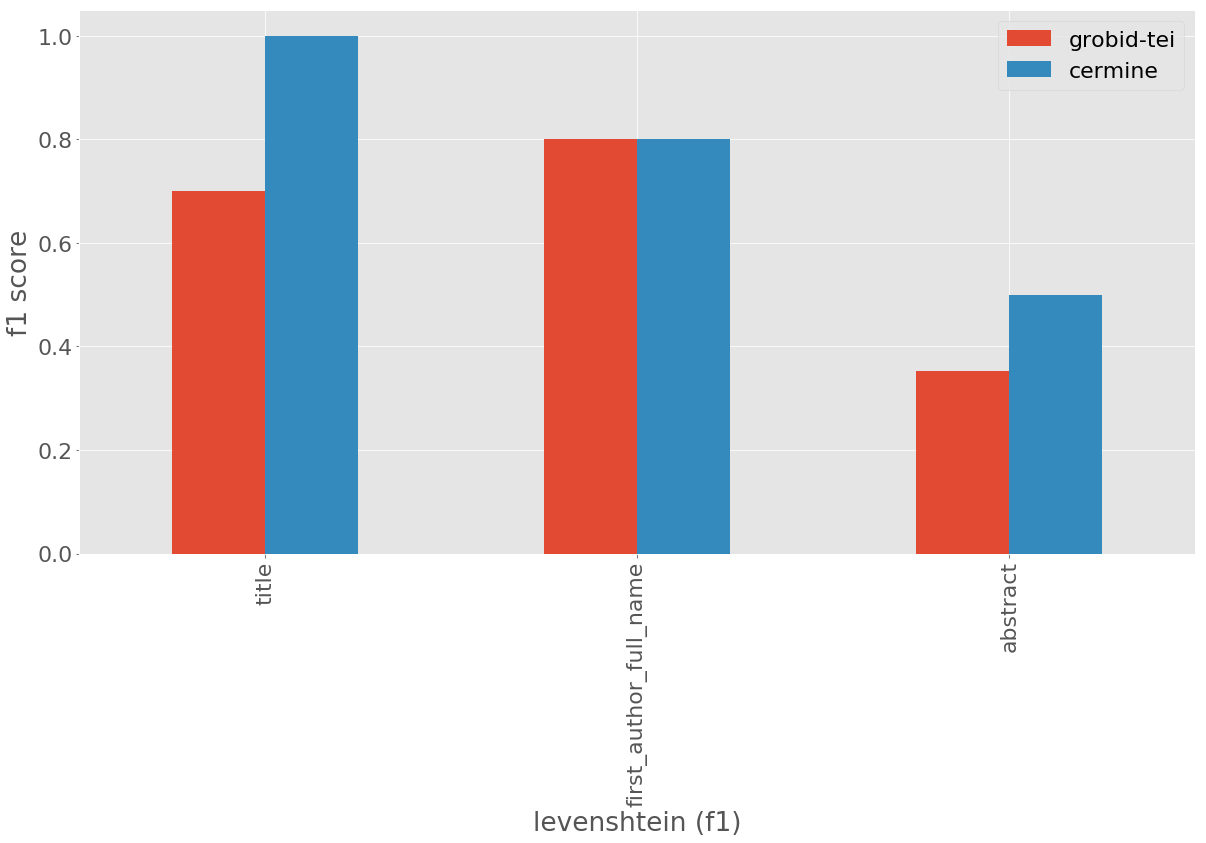

## pmc-sample-1943-cc-by-subset (exact)

**Note:** sample size of **10** is too small to provide a meaningful insight

grobid-tei: #10, cermine: #10 (max: 10)

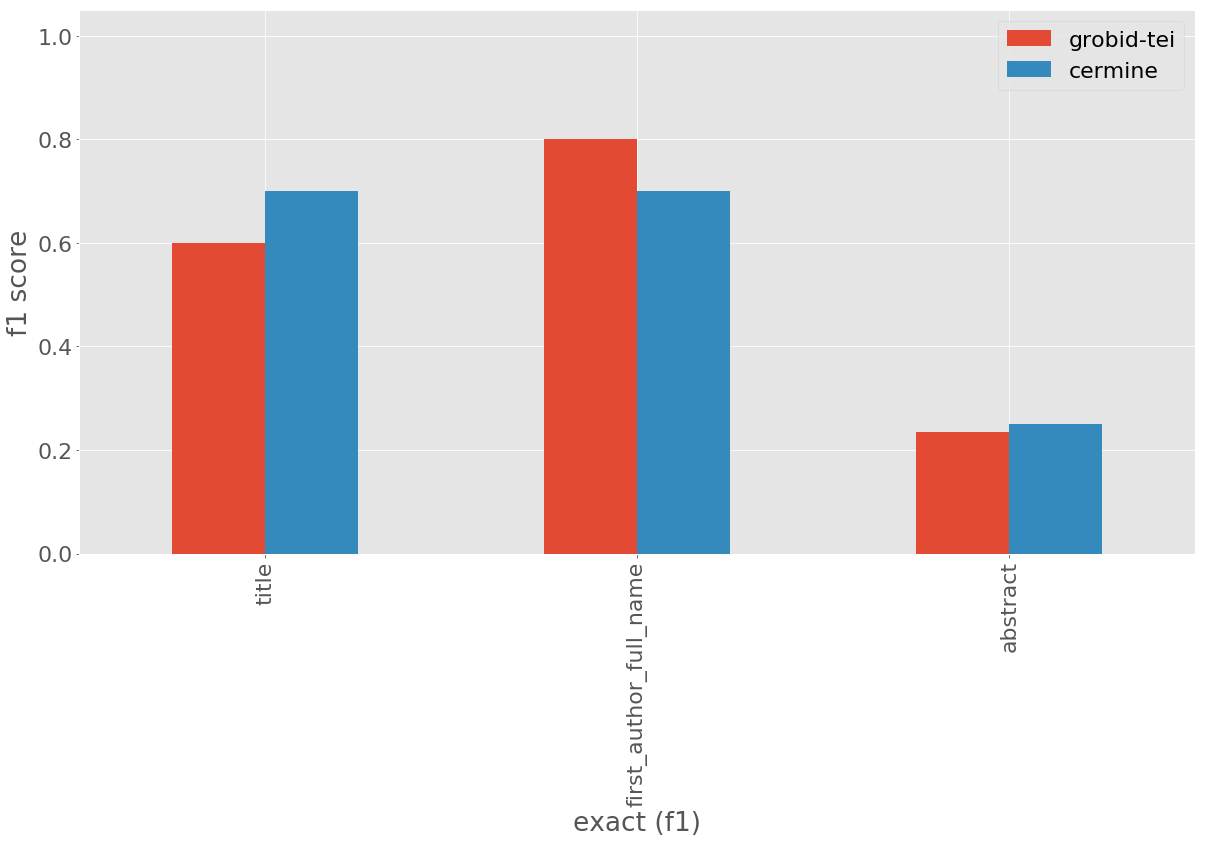

In [15]:
for evaluation_method in evaluation_methods:
    for prefix in prefix_list:
        printmd('## %s (%s)' % (prefix, evaluation_method))
        show_field_summaries(
            [
                (name, df)
                for name, df in all_field_summaries_label_and_df
                if name.startswith(prefix)
            ],
            evaluation_method = evaluation_method, score_name = 'f1', field_names = field_names
        )


In [16]:
def show_comparative_examples(inspect_name, compare_with_name, field_name, evaluation_method, limit=3):
    inspect_df = details_df_map[inspect_name].merge(
        details_df_map[compare_with_name],
        how='outer',
        on=['target_file', 'field_name', 'evaluation_method', 'expected'],
        suffixes=['', '_other']
    )

    title_map = inspect_df[
        (inspect_df['field_name'] == 'title') &
        (inspect_df['evaluation_method'] == 'exact')
    ][['target_file', 'expected']].groupby('target_file').first()['expected'].to_dict()

    inspect_df = inspect_df[inspect_df['field_name'] == field_name]
    inspect_df = inspect_df[inspect_df['evaluation_method'] == evaluation_method]

    printmd('**E**: expected, **A**: %s, **B**: %s (%s %s)' % (
        inspect_name, compare_with_name, field_name, evaluation_method
    ))
    
    short_inspect_name = short_name(inspect_name)
    short_other_name = short_name(compare_with_name)

    incorrect_inspect_df = inspect_df[(inspect_df['tp'] == 0) & (inspect_df['tp_other'] == 1)]
    printmd('#### %s [0 : 1] %s (%d)' % (short_inspect_name, short_other_name, len(incorrect_inspect_df)))
    printmd('There are %d samples where %s got it wrong, but %s got it right.' % (
        len(incorrect_inspect_df), short_inspect_name, short_other_name
    ))
    for row in incorrect_inspect_df[:limit].to_dict(orient='rows'):
        printmd('> `%s` "%s"<br/>**E**: %s<br/>**A**: %s' % (
            row['target_file'], title_map.get(row['target_file']), row['expected'], row['actual']
        ))
    if len(incorrect_inspect_df) > limit:
        print('%d more' % (len(incorrect_inspect_df) - limit))

    correct_inspect_df = inspect_df[(inspect_df['tp'] == 1) & (inspect_df['tp_other'] == 0)]
    printmd('#### %s [1 : 0] %s (%d)' % (short_inspect_name, short_other_name, len(correct_inspect_df)))
    printmd('There are %d samples where %s got it right, but %s got it wrong.' % (
        len(correct_inspect_df), short_inspect_name, short_other_name
    ))
    for row in correct_inspect_df[:limit].to_dict(orient='rows'):
        printmd('> `%s` "%s"<br/>**E**: %s<br/>**B**: %s' % (
            row['target_file'], title_map.get(row['target_file']), row['expected'], row['actual_other']
        ))
    if len(correct_inspect_df) > limit:
        print('%d more' % (len(correct_inspect_df) - limit))

    both_incorrect_inspect_df = inspect_df[(inspect_df['tp'] == 0) & (inspect_df['tp_other'] == 0)]
    printmd('#### %s [0 : 0] %s (%d)' % (short_inspect_name, short_other_name, len(both_incorrect_inspect_df)))
    printmd('There are %d samples where both %s and %s got it wrong.' % (
        len(both_incorrect_inspect_df), short_inspect_name, short_other_name
    ))
    for row in both_incorrect_inspect_df[:limit].to_dict(orient='rows'):
        printmd('> `%s` "%s"<br/>**E**: %s<br/>**A**: %s<br/>**B**: %s' % (
            row['target_file'], title_map.get(row['target_file']),
            row['expected'], row['actual'], row['actual_other']
        ))
    if len(both_incorrect_inspect_df) > limit:
        print('%d more' % (len(both_incorrect_inspect_df) - limit))

printmd('# Comparing results between tools')
for field_name in field_names:
    printmd('<hr/>')
    printmd('# Field: %s' % field_name)
    for evaluation_method in evaluation_methods:
        for prefix in prefix_list:
            printmd('## Dataset: %s (%s %s)' % (prefix, field_name, evaluation_method))
            names_with_prefix = [name for name, _ in all_field_summaries_label_and_df if name.startswith(prefix)]
            for i, inspect_name in enumerate(names_with_prefix[:-1]):
                for other_name in names_with_prefix[(1 + i):]:
                    printmd('### Comparison: %s vs %s' % (short_name(inspect_name), short_name(other_name)))
                    show_comparative_examples(
                        inspect_name, other_name,
                        field_name=field_name, evaluation_method=evaluation_method
                    )

# Comparing results between tools

<hr/>

# Field: title

## Dataset: pmc-sample-1943-cc-by-subset (title levenshtein)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (title levenshtein)

#### grobid-tei [0 : 1] cermine (3)

There are 3 samples where grobid-tei got it wrong, but cermine got it right.

> `d-67-00463.nxml` "pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening"<br/>**E**: pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening<br/>**A**: biological crystallography pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening

> `e-67-o1363.nxml` "3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione"<br/>**E**: 3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione<br/>**A**: e67, o1363-o1364 acta cryst

> `f-67-00344.nxml` "refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins"<br/>**E**: refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins<br/>**A**: structural biology and crystallization communications refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins

#### grobid-tei [1 : 0] cermine (0)

There are 0 samples where grobid-tei got it right, but cermine got it wrong.

#### grobid-tei [0 : 0] cermine (0)

There are 0 samples where both grobid-tei and cermine got it wrong.

## Dataset: pmc-sample-1943-cc-by-subset (title exact)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (title exact)

#### grobid-tei [0 : 1] cermine (1)

There are 1 samples where grobid-tei got it wrong, but cermine got it right.

> `f-67-00344.nxml` "refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins"<br/>**E**: refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins<br/>**A**: structural biology and crystallization communications refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins

#### grobid-tei [1 : 0] cermine (0)

There are 0 samples where grobid-tei got it right, but cermine got it wrong.

#### grobid-tei [0 : 0] cermine (3)

There are 3 samples where both grobid-tei and cermine got it wrong.

> `d-67-00463.nxml` "pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening"<br/>**E**: pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening<br/>**A**: biological crystallography pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening<br/>**B**: pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening research papers

> `e-67-o1363.nxml` "3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione"<br/>**E**: 3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione<br/>**A**: e67, o1363-o1364 acta cryst<br/>**B**: 3-allyl-1-{[3-(4-nitrophenyl)-4,5- dihydro-1,3-oxazol-5-yl]methyl}-1h- anthra[1,2-d]imidazole-2,6,11(3h)- trione

> `ORT-1745-3674-81-405.nxml` "resection arthroplasty for luxation of the manubrio-sternal joint in rheumatoid arthritis—a case report"<br/>**E**: resection arthroplasty for luxation of the manubrio-sternal joint in rheumatoid arthritis—a case report<br/>**A**: resection arthroplasty for luxation of the manubrio-sternal joint in rheumatoid arthritis-a case report<br/>**B**: resection arthroplasty for luxation of the manubrio-sternal joint in rheumatoid arthritis-a case report

<hr/>

# Field: first_author_full_name

## Dataset: pmc-sample-1943-cc-by-subset (first_author_full_name levenshtein)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (first_author_full_name levenshtein)

#### grobid-tei [0 : 1] cermine (2)

There are 2 samples where grobid-tei got it wrong, but cermine got it right.

> `sobs89-975.nxml` "camera trocar lifting in office gasless laparoscopic sterilization under local anesthesia"<br/>**E**: bo s. bergström<br/>**A**: acta obstetricia

> `sonc50-621.nxml` "management of cutaneous metastases using electrochemotherapy"<br/>**E**: louise wichmann matthiessen<br/>**A**: julie gehl

#### grobid-tei [1 : 0] cermine (2)

There are 2 samples where grobid-tei got it right, but cermine got it wrong.

> `apa0100-0653.nxml` "placental programming of blood pressure in indian children"<br/>**E**: nicola r winder<br/>**B**: nicola r winder (nw@mrc.soton.ac.uk)

> `f-67-00344.nxml` "refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins"<br/>**E**: hirotaka narita<br/>**B**: laboratory of supramolecular crystallography

#### grobid-tei [0 : 0] cermine (0)

There are 0 samples where both grobid-tei and cermine got it wrong.

## Dataset: pmc-sample-1943-cc-by-subset (first_author_full_name exact)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (first_author_full_name exact)

#### grobid-tei [0 : 1] cermine (2)

There are 2 samples where grobid-tei got it wrong, but cermine got it right.

> `sobs89-975.nxml` "camera trocar lifting in office gasless laparoscopic sterilization under local anesthesia"<br/>**E**: bo s. bergström<br/>**A**: acta obstetricia

> `sonc50-621.nxml` "management of cutaneous metastases using electrochemotherapy"<br/>**E**: louise wichmann matthiessen<br/>**A**: julie gehl

#### grobid-tei [1 : 0] cermine (3)

There are 3 samples where grobid-tei got it right, but cermine got it wrong.

> `apa0100-0653.nxml` "placental programming of blood pressure in indian children"<br/>**E**: nicola r winder<br/>**B**: nicola r winder (nw@mrc.soton.ac.uk)

> `f-67-00344.nxml` "refolding, crystallization and preliminary x-ray crystallographic study of the whole extracellular regions of nectins"<br/>**E**: hirotaka narita<br/>**B**: laboratory of supramolecular crystallography

> `aas0055-0039.nxml` "phosphate-containing dialysis solution prevents hypophosphatemia during continuous renal replacement therapy"<br/>**E**: m broman<br/>**B**: m. broman

#### grobid-tei [0 : 0] cermine (0)

There are 0 samples where both grobid-tei and cermine got it wrong.

<hr/>

# Field: abstract

## Dataset: pmc-sample-1943-cc-by-subset (abstract levenshtein)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (abstract levenshtein)

#### grobid-tei [0 : 1] cermine (1)

There are 1 samples where grobid-tei got it wrong, but cermine got it right.

> `sonc50-621.nxml` "management of cutaneous metastases using electrochemotherapy"<br/>**E**: background. cutaneous metastases may cause considerable discomfort as a consequence of ulceration, oozing, bleeding and pain. electrochemotherapy has proven to be highly effective in the treatment of cutaneous metastases. electrochemotherapy utilises pulses of electricity to increase the permeability of the cell membrane and thereby augment the effect of chemotherapy. for the drug bleomycin, the effect is enhanced several hundred-fold, enabling once-only treatment. the primary endpoint of this study is to evaluate the efficacy of electrochemotherapy as a palliative treatment. methods. this phase ii study is a collaboration between two centres, one in denmark and the other in the uk. patients with cutaneous metastases of any histology were included. bleomycin was administered intratumourally or intravenously followed by application of electric pulses to the tumour site. results. fifty-two patients were included. complete and partial response rate was 68% and 18%, respectively, for cutaneous metastases <3 cm and 8% and 23%, respectively, for cutaneous metastases >3 cm. treatment was well-tolerated by patients, including the elderly, and no serious adverse events were observed. conclusions. ect is an efficient and safe treatment and clinicians should not hesitate to use it even in the elderly.<br/>**A**: background. cutaneous metastases may cause considerable discomfort as a consequence of ulceration, oozing, bleeding and pain. electrochemotherapy has proven to be highly effective in the treatment of cutaneous metastases. electrochemo-therapy utilises pulses of electricity to increase the permeability of the cell membrane and thereby augment the effect of chemotherapy. for the drug bleomycin, the effect is enhanced several hundred-fold, enabling once-only treatment. the primary endpoint of this study is to evaluate the effi cacy of electrochemotherapy as a palliative treatment. methods. this phase ii study is a collaboration between two centres, one in denmark and the other in the uk. patients with cutaneous metastases of any histology were included. bleomycin was administered intratumourally or intravenously followed by application of electric pulses to the tumour site. results. fifty-two patients were included. complete and partial response rate was 68% and 18%, respectively, for cutaneous metastases 3 cm and 8% and 23%, respectively, for cutaneous metastases 3 cm. treatment was well-tolerated by patients, including the elderly, and no serious adverse events were observed. conclusions. ect is an effi cient and safe treatment and clinicians should not hesitate to use it even in the elderly. a cutaneous metastasis can be defi ned as " a neoplas-tic lesion arising from another neoplasm with which there is no longer continuity " [1]. cutaneous metas-tases account for 0.7% to 9% of all metastases [2]. breast cancer accounts for 51% of the total cases of cutaneous metastases, while malignant melanoma accounts for 18% [3].

#### grobid-tei [1 : 0] cermine (0)

There are 0 samples where grobid-tei got it right, but cermine got it wrong.

#### grobid-tei [0 : 0] cermine (6)

There are 6 samples where both grobid-tei and cermine got it wrong.

> `apa0100-0653.nxml` "placental programming of blood pressure in indian children"<br/>**E**: aim to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (β = 0.69 mmhg/cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (β = 1.40 mmhg/cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth β = −0.68 mmhg/cm, p < 0.05 for all three measurements). conclusions the size and shape of the placental surface predict childhood blood pressure. blood pressure may be programmed by variation in the normal processes of placentation: these include implantation, expansion of the chorionic surface in mid-gestation and compensatory expansion of the chorionic surface in late gestation.<br/>**A**: aim: to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods: we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results: in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (b = 0.69 mmhg ⁄ cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (b = 1.40 mmhg ⁄ cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth b =)0.68 mmhg ⁄ cm, p < 0.05 for all three measurements).<br/>**B**: aim: to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods: we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results: in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (b = 0.69 mmhg ? cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (b = 1.40 mmhg ? cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth b = )0.68 mmhg ? cm, p < 0.05 for all three measurements).

> `d-67-00463.nxml` "pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening"<br/>**E**: pi sampling, derived from the incomplete factorial approach, is an effort to maximize the diversity of macromolecular crystallization conditions and to facilitate the preparation of 96-condition initial screens.the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting ‘pi screens’ have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.<br/>**A**: the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting 'pi screens' have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.<br/>**B**: the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting 'pi screens' have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.

> `e-67-o1363.nxml` "3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione"<br/>**E**: the mol­ecular structure of the title compound, c28h20n4o6, consists of three fused six-membered rings (a,b,c) and one five-membered ring (d). the latter is linked to an isoxazole ring (e) via a methyl­ene unit. a 4-nitro-phenyl substituent (f) is attached to the isoxazole. the fused five and six-membered rings (c,d) are almost coplanar with an r.m.s. deviation of 0.0345 å and make a dihedral angle of 9.40 (8)° with ring a. the isoxazole and 4-nitro-phenyl rings (e,f) are also almost coplanar with the imidazole and the fused adjacent ring (c,d), forming a dihedral angle of 11.4 (6)°. the crystal packing displays inter­molecular c—h⋯o hydrogen bonding. an intra­molecular c—h⋯o inter­action also occurs.<br/>**A**: key indicators: single-crystal x-ray study; t = 296 k; mean (c-c) = 0.003 a ˚ ; r factor = 0.040; wr factor = 0.111; data-to-parameter ratio = 14.1. the molecular structure of the title compound, c 28 h 20 n 4 o 6 , consists of three fused six-membered rings (a,b,c) and one five-membered ring (d). the latter is linked to an isoxazole ring (e) via a methylene unit. a 4-nitro-phenyl substituent (f) is attached to the isoxazole. the fused five and six-membered rings (c,d) are almost coplanar with an r.m.s. deviation of 0.0345 a ˚ and make a dihedral angle of 9.40 (8) with ring a. the isoxazole and 4-nitro-phenyl rings (e,f) are also almost coplanar with the imidazole and the fused adjacent ring (c,d), forming a dihedral angle of 11.4 (6). the crystal packing displays intermolecular c-há á áo hydrogen bonding. an intramolecular c-há á áo interaction also occurs.<br/>**B**: nan

3 more


## Dataset: pmc-sample-1943-cc-by-subset (abstract exact)

### Comparison: grobid-tei vs cermine

**E**: expected, **A**: pmc-sample-1943-cc-by-subset grobid-tei, **B**: pmc-sample-1943-cc-by-subset cermine (abstract exact)

#### grobid-tei [0 : 1] cermine (0)

There are 0 samples where grobid-tei got it wrong, but cermine got it right.

#### grobid-tei [1 : 0] cermine (0)

There are 0 samples where grobid-tei got it right, but cermine got it wrong.

#### grobid-tei [0 : 0] cermine (8)

There are 8 samples where both grobid-tei and cermine got it wrong.

> `apa0100-0653.nxml` "placental programming of blood pressure in indian children"<br/>**E**: aim to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (β = 0.69 mmhg/cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (β = 1.40 mmhg/cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth β = −0.68 mmhg/cm, p < 0.05 for all three measurements). conclusions the size and shape of the placental surface predict childhood blood pressure. blood pressure may be programmed by variation in the normal processes of placentation: these include implantation, expansion of the chorionic surface in mid-gestation and compensatory expansion of the chorionic surface in late gestation.<br/>**A**: aim: to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods: we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results: in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (b = 0.69 mmhg ⁄ cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (b = 1.40 mmhg ⁄ cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth b =)0.68 mmhg ⁄ cm, p < 0.05 for all three measurements).<br/>**B**: aim: to determine whether the size and shape of the placental surface predict blood pressure in childhood. methods: we studied blood pressure in 471 nine-year-old indian children whose placental length, breadth and weight were measured in a prospective birth cohort study. results: in the daughters of short mothers (<median height), systolic blood pressure (sbp) rose as placental breadth increased (b = 0.69 mmhg ? cm, p = 0.05) and as the ratio of placental surface area to birthweight increased (p = 0.0003). in the daughters of tall mothers, sbp rose as the difference between placental length and breadth increased (b = 1.40 mmhg ? cm, p = 0.007), that is as the surface became more oval. among boys, associations with placental size were only statistically significant after adjusting for current bmi and height. after adjustment, sbp rose as placental breadth, area and weight decreased (for breadth b = )0.68 mmhg ? cm, p < 0.05 for all three measurements).

> `d-67-00463.nxml` "pi sampling: a methodical and flexible approach to initial macromolecular crystallization screening"<br/>**E**: pi sampling, derived from the incomplete factorial approach, is an effort to maximize the diversity of macromolecular crystallization conditions and to facilitate the preparation of 96-condition initial screens.the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting ‘pi screens’ have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.<br/>**A**: the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting 'pi screens' have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.<br/>**B**: the pi sampling method is derived from the incomplete factorial approach to macromolecular crystallization screen design. the resulting 'pi screens' have a modular distribution of a given set of up to 36 stock solutions. maximally diverse conditions can be produced by taking into account the properties of the chemicals used in the formulation and the concentrations of the corresponding solutions. the pi sampling method has been implemented in a web-based application that generates screen formulations and recipes. it is particularly adapted to screens consisting of 96 different conditions. the flexibility and efficiency of pi sampling is demonstrated by the crystallization of soluble proteins and of an integral membrane-protein sample.

> `e-67-o1363.nxml` "3-allyl-1-{[3-(4-nitro­phen­yl)-4,5-dihydro-1,3-oxazol-5-yl]meth­yl}-1h-anthra[1,2-d]imidazole-2,6,11(3h)-trione"<br/>**E**: the mol­ecular structure of the title compound, c28h20n4o6, consists of three fused six-membered rings (a,b,c) and one five-membered ring (d). the latter is linked to an isoxazole ring (e) via a methyl­ene unit. a 4-nitro-phenyl substituent (f) is attached to the isoxazole. the fused five and six-membered rings (c,d) are almost coplanar with an r.m.s. deviation of 0.0345 å and make a dihedral angle of 9.40 (8)° with ring a. the isoxazole and 4-nitro-phenyl rings (e,f) are also almost coplanar with the imidazole and the fused adjacent ring (c,d), forming a dihedral angle of 11.4 (6)°. the crystal packing displays inter­molecular c—h⋯o hydrogen bonding. an intra­molecular c—h⋯o inter­action also occurs.<br/>**A**: key indicators: single-crystal x-ray study; t = 296 k; mean (c-c) = 0.003 a ˚ ; r factor = 0.040; wr factor = 0.111; data-to-parameter ratio = 14.1. the molecular structure of the title compound, c 28 h 20 n 4 o 6 , consists of three fused six-membered rings (a,b,c) and one five-membered ring (d). the latter is linked to an isoxazole ring (e) via a methylene unit. a 4-nitro-phenyl substituent (f) is attached to the isoxazole. the fused five and six-membered rings (c,d) are almost coplanar with an r.m.s. deviation of 0.0345 a ˚ and make a dihedral angle of 9.40 (8) with ring a. the isoxazole and 4-nitro-phenyl rings (e,f) are also almost coplanar with the imidazole and the fused adjacent ring (c,d), forming a dihedral angle of 11.4 (6). the crystal packing displays intermolecular c-há á áo hydrogen bonding. an intramolecular c-há á áo interaction also occurs.<br/>**B**: nan

5 more
